In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from utils import *
from torchani.units import HARTREE_TO_KCALMOL
from matplotlib import pyplot as plt

In [3]:
smaller_size = 22
title_size = 26
tick_size = 14

In [2]:
a = np.load('/home/shuhaozh/rxn-ani-pub/test/TS_dataset/b97d3_extended/4.npz')

In [7]:
b97d3_folder = Path('/home/shuhaozh/rxn-ani-pub/test/TS_dataset/b97d3_extended')

In [9]:
count = 0
for f in b97d3_folder.glob('*.npz'):
    a = np.load(f)
    count += len(a['name'])

print(count)

16279


In [3]:
def process_a_block(block, model, device):
    
    r_info = (torch.tensor(block['rn']).to(device), torch.tensor(block['rc'], dtype=torch.float32).to(device))
    _, r_e = model(r_info)
    
    p_info = (torch.tensor(block['pn']).to(device), torch.tensor(block['pc'], dtype=torch.float32).to(device))
    _, p_e = model(p_info)
    
    ts_info = (torch.tensor(block['tsn']).to(device), torch.tensor(block['tsc'], dtype=torch.float32).to(device))
    _, ts_e = model(ts_info)
    
    return r_e.cpu().numpy(), p_e.cpu().numpy(), ts_e.cpu().numpy()

def test_TS_dataset(model, working_df, test_name, ref_extend_key='_b973c_Etemp5000K', 
                    datadir=Path('/home/shuhaozh/rxn-ani-pub/test/TS_dataset/b97d3_extended'), device='cuda:1'):
    
    temp = ['renergy', 'penergy', 'tsenergy']
    #pred_keys = [k+'_'+test_name for k in temp]
    ref_keys = [k+ref_extend_key for k in temp]

    predictions = {k:[] for k in temp}
    ref = {k:[] for k in temp}

    need_ref = len(working_df.columns) == 0

    for f in datadir.glob('*.npz'):
        block = np.load(f)
        for k,p in zip(temp, process_a_block(block, model, device)):
            predictions[k].append(p)

        for k, ek in zip(temp, ref_keys):
            ref[k].append(block[ek])
        
    predictions = {k:np.concatenate(v) for k,v in predictions.items()}
    ref = {k:np.concatenate(v) for k,v in ref.items()}
    
    # add them as columns to the working_df
    working_df['P-R_diff'+'_'+test_name] = (predictions['penergy'] - predictions['renergy'] - (ref['penergy'] - ref['renergy']))*HARTREE_TO_KCALMOL
    working_df['TS-R_diff'+'_'+test_name] = (predictions['tsenergy'] - predictions['renergy'] - (ref['tsenergy'] - ref['renergy']))*HARTREE_TO_KCALMOL
    working_df['TS-P_diff'+'_'+test_name] = (predictions['tsenergy'] - predictions['penergy'] - (ref['tsenergy'] - ref['penergy']))*HARTREE_TO_KCALMOL

    return working_df

In [5]:
MODEL_TO_TEST = [
    '/home/shuhaozh/rxn-ani-pub/trained_models/compiled/init_ani1xT5000hartree_lrs1e-3_lrs1e-6_p10_best_compiled.jpt',
    '/home/shuhaozh/rxn-ani-pub/trained_models/compiled/init_ani1x_bbT5000_b24576_lrs1e-3_lrs1e-6_p10_best_compiled.jpt',
    '/home/shuhaozh/rxn-ani-pub/trained_models/compiled/init_ani1x_ani1xT5000+bbT5000_b24576_lrs1e-3_lrs1e-6_p10_best_compiled.jpt',
]

#TEST_NAMES = ['ANI1x_b973cT5000', 'b973c_bbT5000', 'ANI1x+bb_b973c_T5000']
TEST_NAMES = ['A', 'B', 'C']
device = 'cuda:1'

In [14]:
#create an empty working_df
working_df = pd.DataFrame()
#datadir = Path('/home/shuhaozh/rxn-ani-pub/test/TS_dataset/wb97xd3_extended')
datadir = Path('/home/shuhaozh/rxn-ani-pub/test/TS_dataset/b97d3_extended')

for n, model in zip(TEST_NAMES, MODEL_TO_TEST):
    model = torch.load(model)
    model.requires_grad_(False)
    model.periodic_table_index = True
    model = model.to(device)

    working_df = test_TS_dataset(model, working_df, n, ref_extend_key='_b973c_Etemp5000K', datadir=datadir, device=device)

In [15]:
working_df

,P-R_diff_A,TS-R_diff_A,TS-P_diff_A,P-R_diff_B,TS-R_diff_B,TS-P_diff_B,P-R_diff_C,TS-R_diff_C,TS-P_diff_C
0,45.867946,34.418585,-11.449361,0.995392,-3.581876,-4.577267,0.313157,0.943530,0.630373
1,19.016935,21.981872,2.964938,1.812234,5.464953,3.652718,4.222675,8.181524,3.958849
2,14.781091,-0.922836,-15.703927,2.296195,-5.818295,-8.114490,6.080226,-12.561933,-18.642159
3,41.746991,23.216954,-18.530037,-0.160836,-15.129781,-14.968945,0.171990,-3.235543,-3.407532
4,2.230101,-17.383904,-19.614005,-0.558996,1.963947,2.522943,1.489058,-1.944149,-3.433207
...,...,...,...,...,...,...,...,...,...
16274,1.005451,-11.233178,-12.238629,0.253776,-16.370058,-16.623834,1.902220,-7.339980,-9.242200
16275,-3.229745,-18.381447,-15.151702,1.298321,3.873223,2.574901,2.187090,-1.314625,-3.501715
16276,-28.808884,-28.922812,-0.113928,-3.484748,-7.767744,-4.282997,-4.805766,-8.097389,-3.291623
16277,1.522211,-2.968692,-4.490903,2.313994,-24.102453,-26.416448,1.948074,-11.279836,-13.227911


In [16]:
working_df.to_csv('./TS_dataset_b97d3part_recalculated_test_results.csv')

In [17]:
np.sort(np.array(working_df.columns))

array(['P-R_diff_A', 'P-R_diff_B', 'P-R_diff_C', 'TS-P_diff_A',
       'TS-P_diff_B', 'TS-P_diff_C', 'TS-R_diff_A', 'TS-R_diff_B',
       'TS-R_diff_C'], dtype=object)

P-R_diff_A P-R_diff_B P-R_diff_C
TS-P_diff_A TS-P_diff_B TS-P_diff_C
TS-R_diff_A TS-R_diff_B TS-R_diff_C
P-R_diff_A P-R_diff_B P-R_diff_C
TS-P_diff_A TS-P_diff_B TS-P_diff_C
TS-R_diff_A TS-R_diff_B TS-R_diff_C


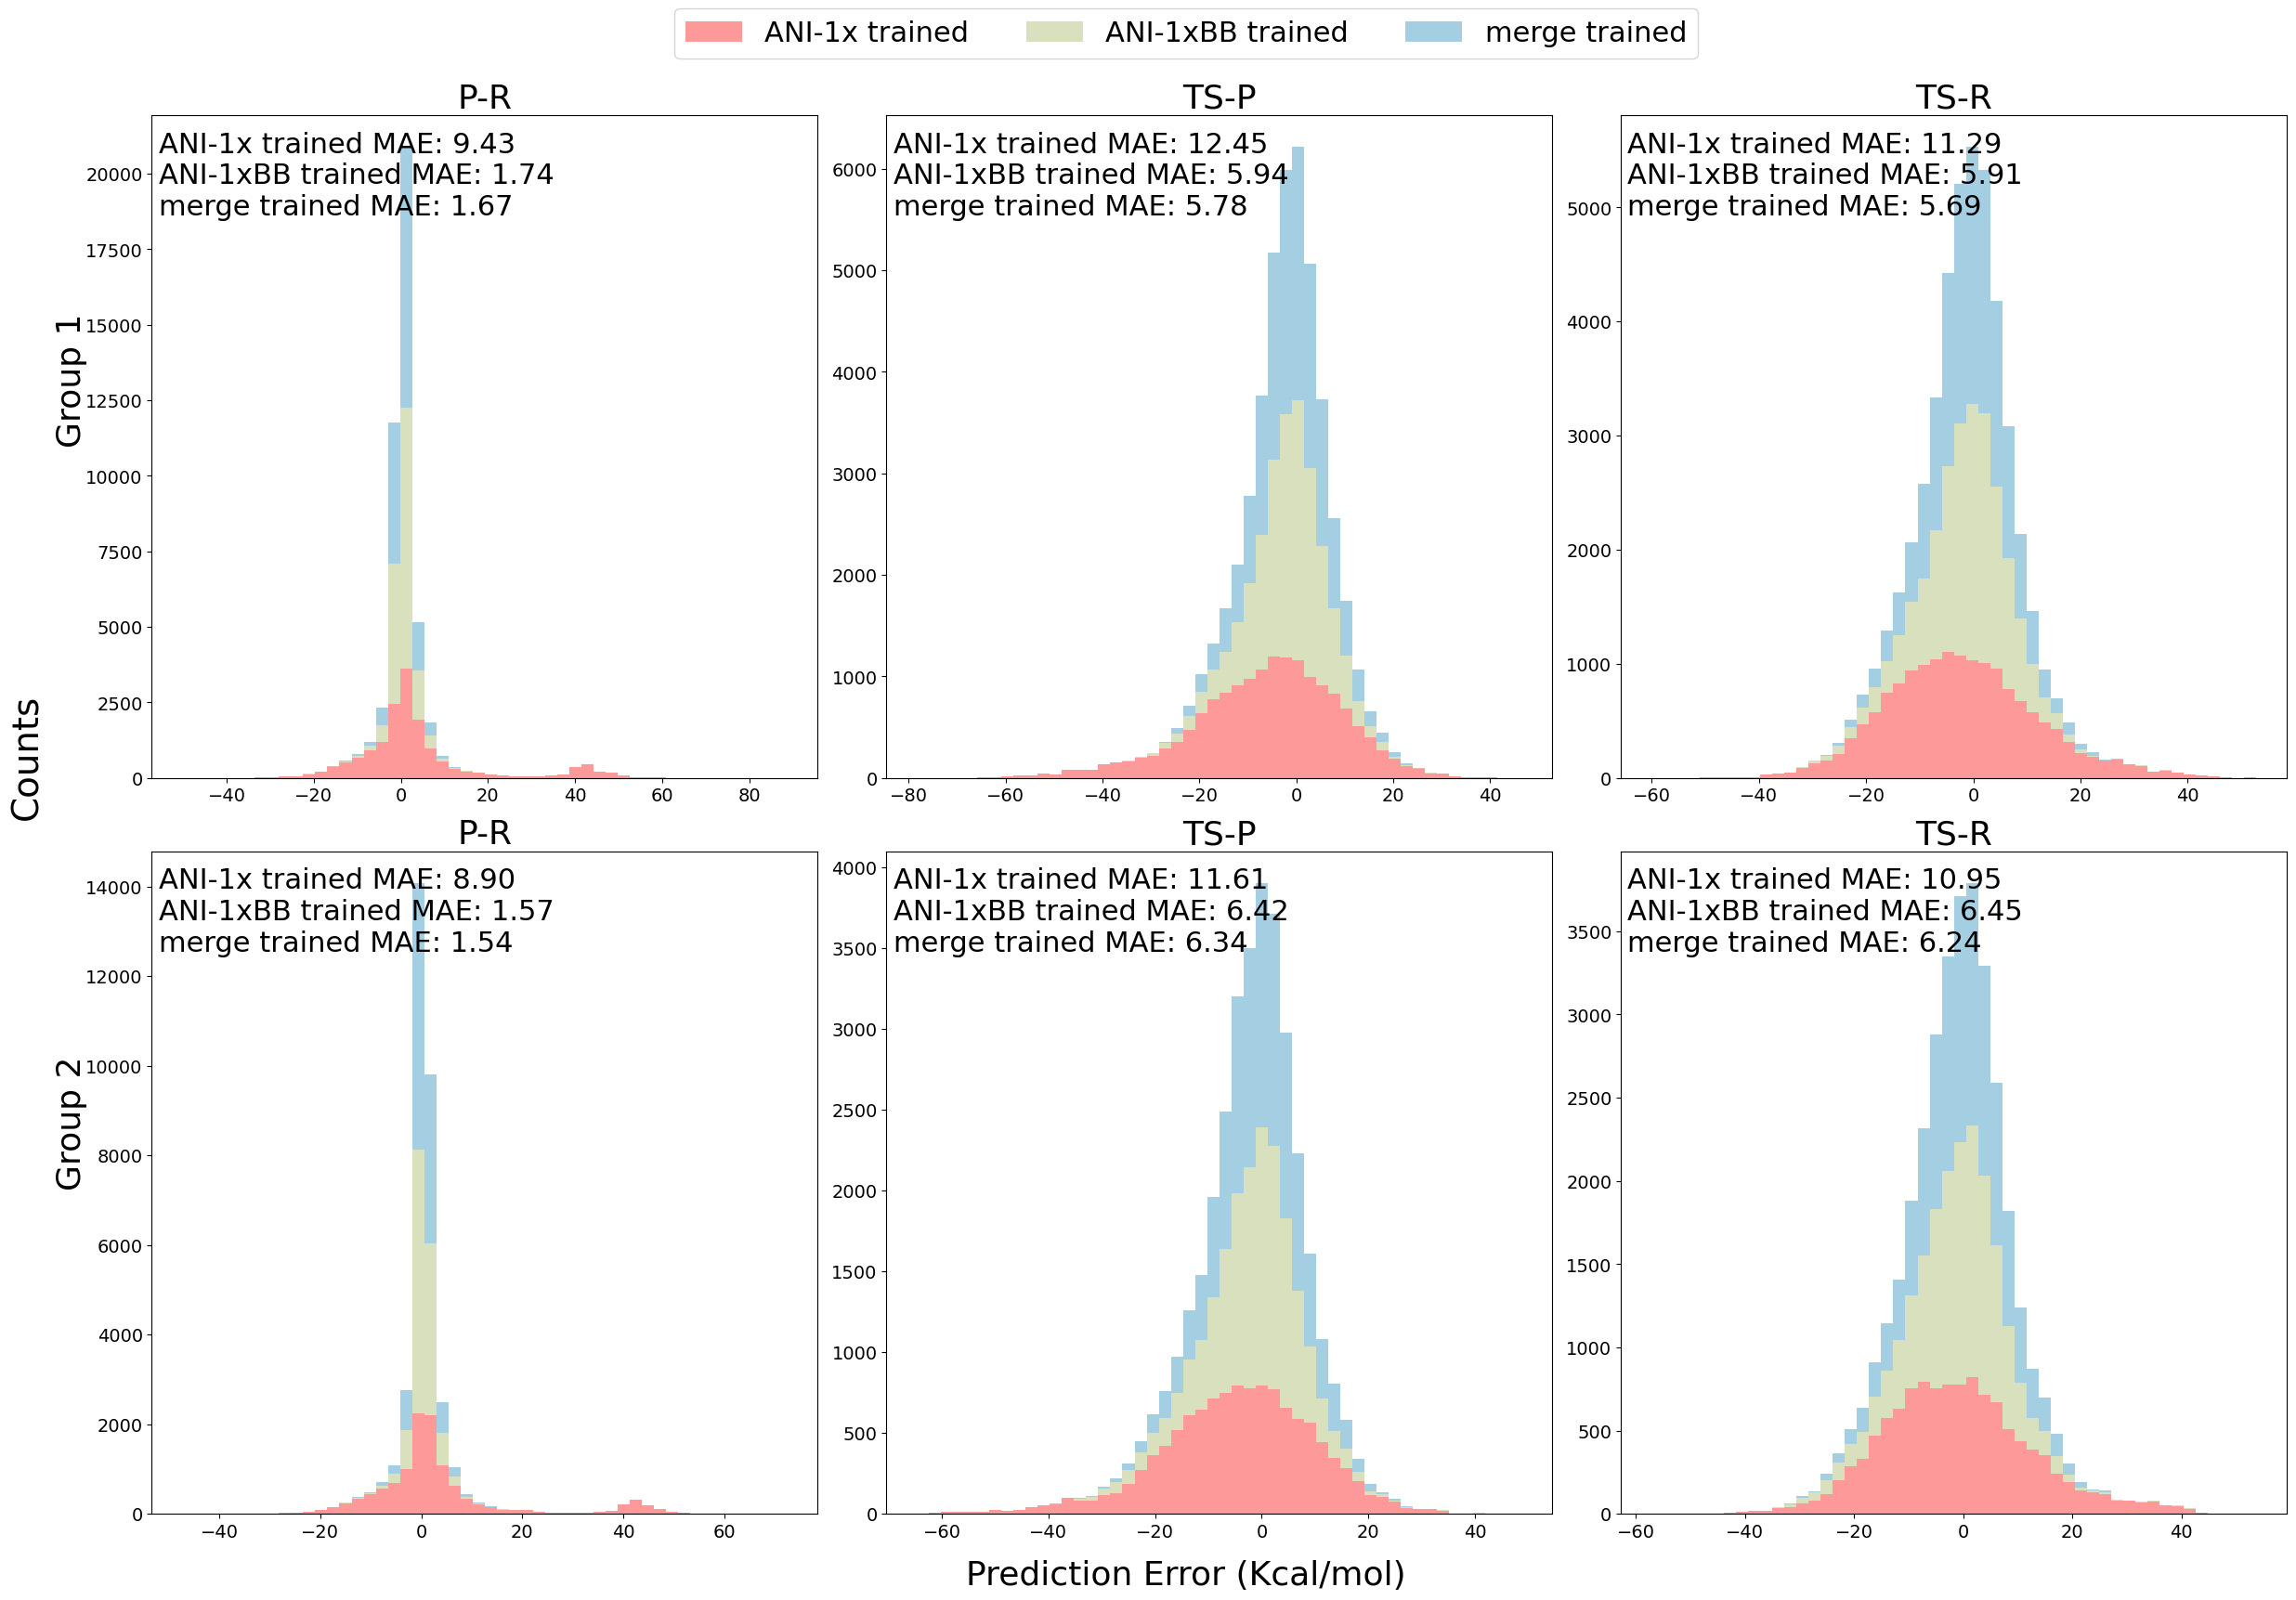

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16))


for i in range(6):
    if i == 0:
        working_df = pd.read_csv('./TS_dataset_b97d3part_recalculated_test_results.csv', index_col=0)
    elif i == 3:
        working_df = pd.read_csv('./TS_dataset_wb97xd3part_recalculated_test_results.csv', index_col=0)


    keys = np.sort(np.array(working_df.columns))
    
    k1, k2, k3 = keys[i%3*3], keys[i%3*3+1], keys[i%3*3+2]
    print(k1, k2, k3)
    e1, e2, e3 = working_df[k1].dropna(), working_df[k2].dropna(), working_df[k3].dropna()
    subtitle = k1.split('_')[0]

    mae1 = np.abs(e1).mean()
    mae2 = np.abs(e2).mean()
    mae3 = np.abs(e3).mean()

    to_hist = [e1, e2, e3]
    ax = axes[i//3, i%3]
    #make overlap histogram
    k1 = 'ANI-1x trained'
    k2 = 'ANI-1xBB trained'
    k3 = 'merge trained'
    #color=['#B40636', '#E4A259', '#21A9C8'] red, orange, blue
    ax.hist(to_hist, bins=50, stacked=True, label=[k1, k2 ,k3], color=['#FD9999', '#D9E0BE', '#A4CEE1'])
    #ax.hist(to_hist, bins=50, density=True,  label=[k1, k2 ,k3], color=['#FD9999', '#D9E0BE', '#A4CEE1'])
    ax.set_title(subtitle, fontsize=title_size)

    #set tick size
    ax.tick_params(axis='both', which='major', labelsize=tick_size) 

    #write down two MAEs
    ax.text(0.01, 0.85, '%s MAE: %.2f\n%s MAE: %.2f\n%s MAE: %.2f' % (k1, mae1, k2, mae2, k3, mae3), transform=ax.transAxes, fontsize=smaller_size)

#add shared x and y labels, but do not merge xticks and yticks
fig.text(0.5, -0.02, 'Prediction Error (Kcal/mol)', ha='center', fontsize=title_size)
fig.text(0.0, 0.75, 'Group 1', ha='center', rotation='vertical', fontsize=title_size)
fig.text(0.0, 0.25, 'Group 2', ha='center', rotation='vertical', fontsize=title_size)
fig.text(-0.02, 0.5, 'Counts', ha='center', rotation='vertical', fontsize=title_size+2)

# add title for the whole figure
#fig.text(0.5, 1.08, 'Group 2', ha='center', fontsize=title_size+2)
#add legend on top, outside of the subplots
fig.legend([k1, k2, k3], bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=3, fontsize=smaller_size)

plt.tight_layout()
plt.show()

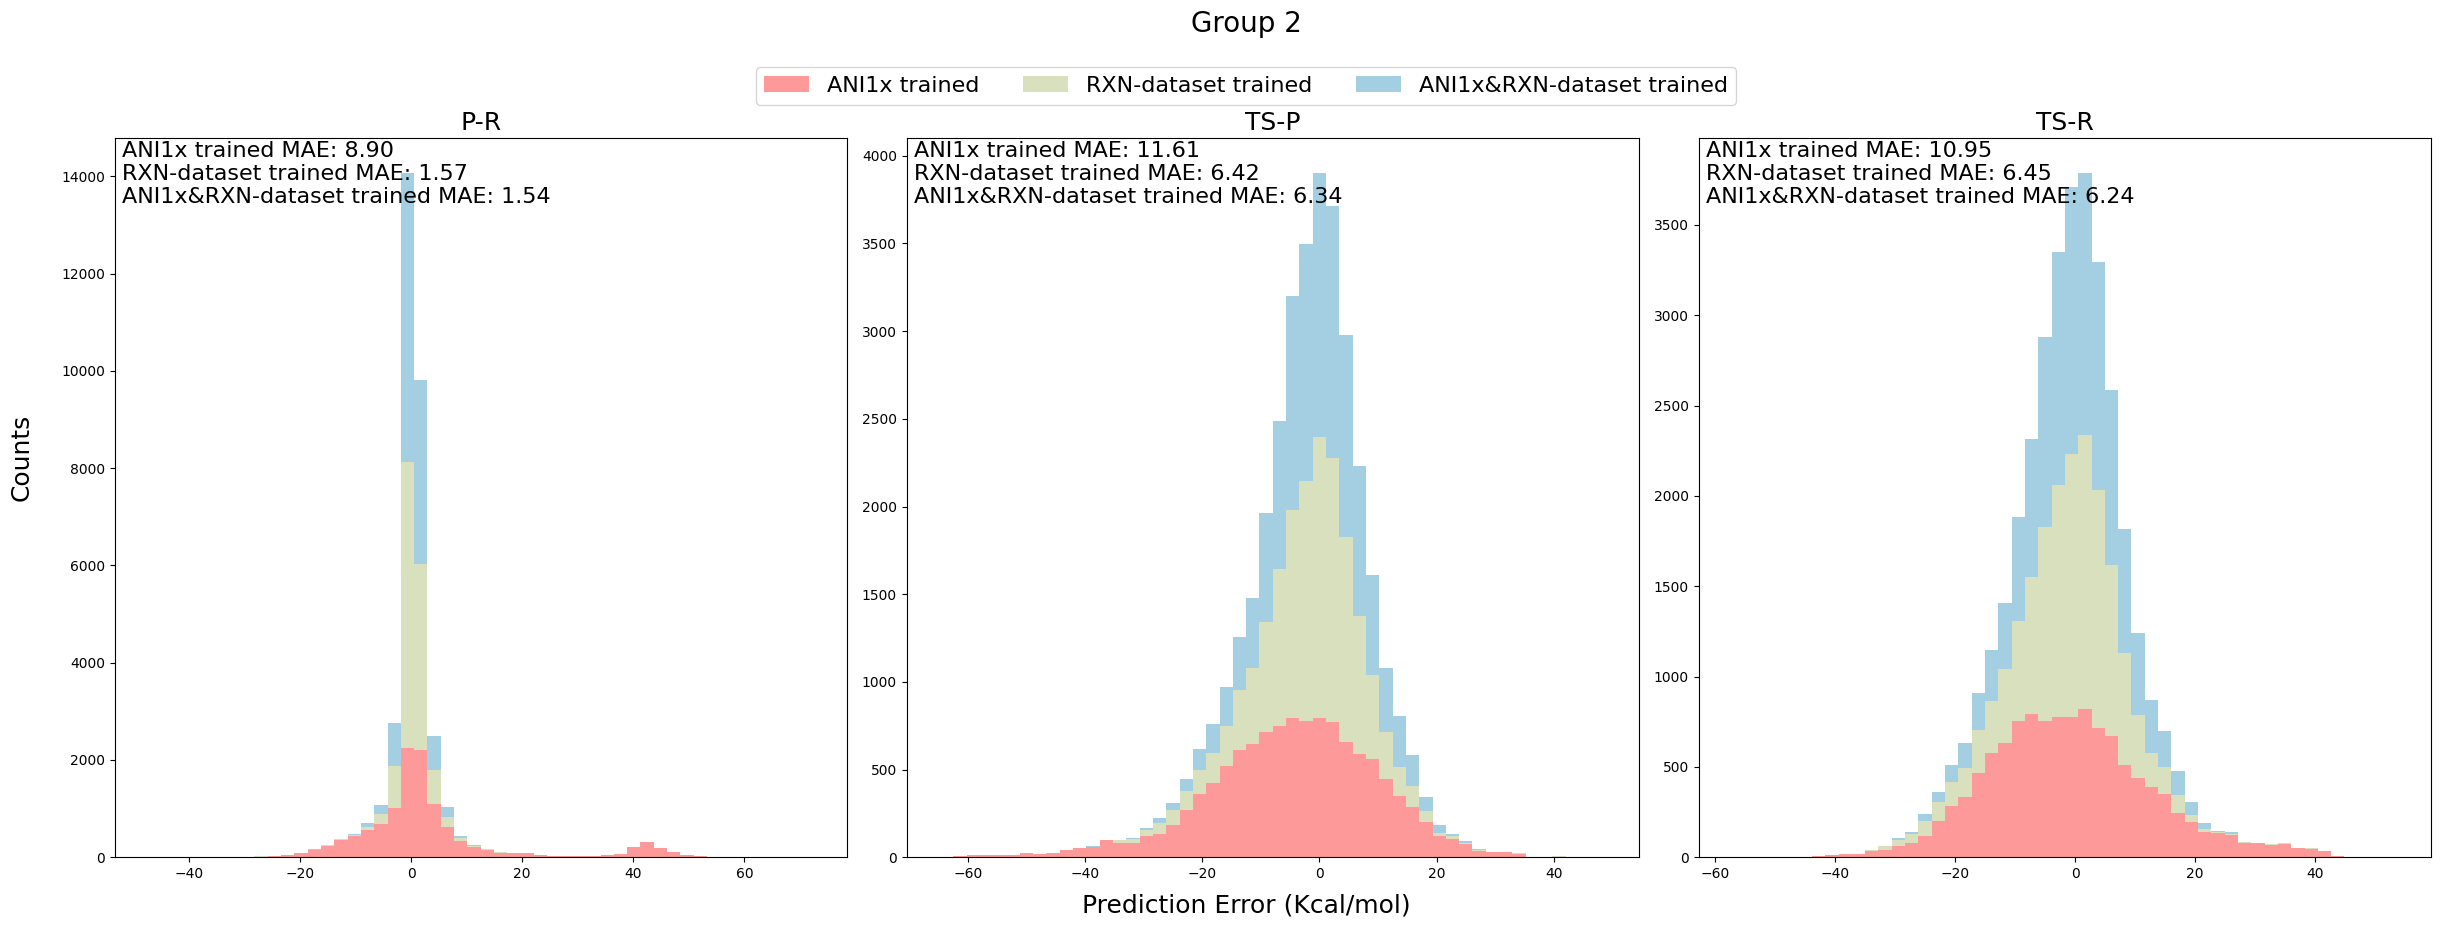

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
keys = np.sort(np.array(working_df.columns))

for i in range(3):
    
    k1, k2, k3 = keys[i*3], keys[i*3+1], keys[i*3+2]
    e1, e2, e3 = working_df[k1].dropna(), working_df[k2].dropna(), working_df[k3].dropna()
    subtitle = k1.split('_')[0]

    mae1 = np.abs(e1).mean()
    mae2 = np.abs(e2).mean()
    mae3 = np.abs(e3).mean()

    to_hist = [e1, e2, e3]
    ax = axes[i%3]
    #make overlap histogram
    k1 = 'ANI1x trained'
    k2 = 'RXN-dataset trained'
    k3 = 'ANI1x&RXN-dataset trained'
    #color=['#B40636', '#E4A259', '#21A9C8'] red, orange, blue
    ax.hist(to_hist, bins=50, stacked=True, label=[k1, k2 ,k3], color=['#FD9999', '#D9E0BE', '#A4CEE1'])
    ax.set_title(subtitle, fontsize=title_size)

    #write down two MAEs
    ax.text(0.01, 0.91, '%s MAE: %.2f\n%s MAE: %.2f\n%s MAE: %.2f' % (k1, mae1, k2, mae2, k3, mae3), transform=ax.transAxes, fontsize=smaller_size)

#add shared x and y labels, but do not merge xticks and yticks
fig.text(0.5, -0.02, 'Prediction Error (Kcal/mol)', ha='center', fontsize=title_size)
fig.text(-0.01, 0.5, 'Counts', ha='center', rotation='vertical', fontsize=title_size)

# add title for the whole figure
fig.text(0.5, 1.08, 'Group 2', ha='center', fontsize=title_size+2)
#add legend on top, outside of the subplots
fig.legend([k1, k2, k3], bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=3, fontsize=smaller_size)

plt.tight_layout()
plt.show()

In [62]:
k1

'ANI1x'